In [1]:
import torch
import matplotlib.pyplot as plt


# Here are some plot styles, which primarily make this plot larger for display
# purposes.
parameters = {'axes.labelsize': 18,
              'legend.fontsize': 18,
              'xtick.labelsize':16,
              'ytick.labelsize':16,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)

# Multi-Layer Perceptron Tutorial

## About this tutorial
This tutorial focuses on the practical theory and implementation of perceptrons with a focus on introducing [PyTorch](https://pytorch.org/) python library and its autodifferentiation features. 

This tutorial will guide you through the creation of a Perceptron classifier to identify penguins based on their measurements.

This tutorial presumes you are minimally familiar with the python programming language, and benefits from a basic familiarity of the [NumPy](https://numpy.org/) and [matplotlib](https://matplotlib.org/) libraries. We'll also use the [pandas library](https://pandas.pydata.org/) for some few things. Don't worry, we'll go over how to use each briefly.


## Other resources

* Learnxinyminutes.com has [a good refresher for python](https://learnxinyminutes.com/docs/python/).
* A quick [cheat sheet for pandas](https://duckduckgo.com/?q=pandas+cheat+sheet&ia=cheatsheet&iax=cheatsheet) (we'll not be using this very much)
* A similar [cheat sheet for numpy](https://duckduckgo.com/?q=numpy+cheat+sheet&ia=cheatsheet&iax=1)
* [Documentation for PyTorch](https://pytorch.org/docs/stable/index.html)


## About this notebook

This notebook was written in Google's Colab platform (which you are likely on now). The Colab platform provides you with free CPU and GPU resources, and comes with all the python modules we'll need for this tutorial.

If you require to run this notebook on your own computer, you'll need to download this notebook and the libraries we use here.

You'll need:
1. A Python Environment (consider installing [Anaconda](https://www.anaconda.com/products/individual#Downloads))
2. And the following libraries, which can be install with `pip`

- `torch`
- `numpy`
- `matplotlib`
- `pandas`
- `jupyter`
- `jupyterlab` (optional)

# The Perceptron

## Background

In the late 1950s, Cornell psychologist [Frank Rosenblatt](https://en.wikipedia.org/wiki/Frank_Rosenblatt) undertook the task of creating **an electronic device with the ability to learn**, and what's more, to do so using [neurobiological](https://www.sciencedaily.com/terms/neurobiology.htm) principles.

Rosenblatt named his device **the perceptron**, and was able to complete tasks such as determining whether an object was a triangle or not, simply from having seen (labelled) images that *did* or *did not* contain triangles.

While it required very specialised and expensive hardware at the time to create, we can recreate it on our computers quite easily today, which we'll see shortly.

![Mark I Perceptron](https://upload.wikimedia.org/wikipedia/en/5/52/Mark_I_perceptron.jpeg)

_([Cornell Aeronautical Laboratory](https://en.wikipedia.org/wiki/File:Mark_I_perceptron.jpeg))_




## The Perceptron Classifier Function

A perceptron is an algorithm for learning **linear, binary classifier**. That is to say, given some input $X$, a perceptron learns a linear function $f$ which is able to predict a label $y \in Y$ where $Y = [-1,1]$ by performing the operation $f(x)=y$. 


### The Neuron Analogy

While neuron biology is a bit tangential to this course, Rosenblatt conceived of perceptrons as electronic simulations of neurons, the [integration of neurobiology and deep learning](https://www.frontiersin.org/articles/10.3389/fncom.2016.00094/full) is an active field of research, and it is often a helpful analogy for understanding why perceptrons are formulated the way they are.

While it takes complex computer models to create realistic models of how neurons work, simplistic models of neurons, such as the perceptron, have been shown to be sufficient to model many neuronal behaviours.

The perceptron models the behaviour of neurons which receive electrical stimuli from its dendrites and then releases an output from the axon terminal. The axon terminals then release neurotransmitters and/or electrical signals to one or more dendrites. The neuron only releases these signals when the electrical stimulus at the dendrite meet some threshold (known as the "action potential").

In this way, neurons integrate and selectively propogate signals to perform cognitive functions.

![Diagram of Neuron Anatomy](https://upload.wikimedia.org/wikipedia/commons/4/44/Neuron3.png)

_([Prof. Loc Vu-Quoc](https://commons.wikimedia.org/wiki/File:Neuron3.png), [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en))_

### Defining the Perceptron

The function $f$ is a peice-wise function defined as follows:

$$
f(X)=  \begin{cases} 
      1 & W\cdot X + b > 0\\
      -1 & W\cdot X + b < 0
   \end{cases}
$$

where $W$ is a weight parameter and $b$ is a bias parameter, both of which are learned by the perceptron algorithm.

You can also restate this as

$$
f(X) = \textrm{Sign}\left(b + \sum_{i=0}^n w_i x_i\right)
$$

Where $\textrm{Sign}(x)$ is the [sign function](https://en.wikipedia.org/wiki/Sign_function), which returns $-1$ if $x < 0$ and returns $1$ otherwise.

We can even forego the bias term $b$ if we ensure that $W$ always has an extra element whose value is always equal $1$.

$$
f(X) = \textrm{Sign}\left(\sum_{i=0}^n w_i x_i\right)
$$

PyTorch has an implementation of the sign function named [`torch.sign`](https://pytorch.org/docs/stable/generated/torch.sign.html).

Plotted, the Sign function looks like this:

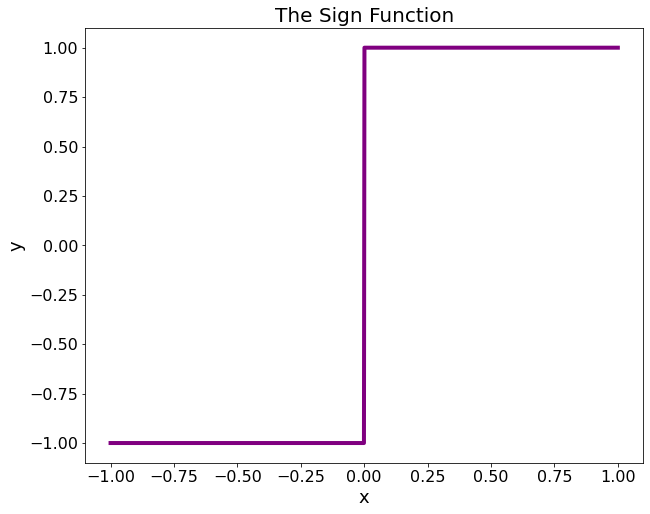

In [2]:
import matplotlib.pyplot as plt

# creates 1000 numbers between -1 and 1, evenly spaced
x = torch.linspace(-1,1,1000)

# make a plot of size (10,8)
fig, ax = plt.subplots(figsize=(10,8))

# set the title of the plot
plt.title('The Sign Function')

# plot x by torch.sign(x)
# make the line 4 px wide and purple
plt.plot(x, torch.sign(x), linewidth=4, color='purple')

# label the axes
plt.xlabel('x')
plt.ylabel('y')
None

# Preparing Data

## Gentoo and Adelie Penguins

To demonstrate how perceptrons work (as well as when they do not), we'll need to use an example dataset. The [Palmer Penguin](https://allisonhorst.github.io/palmerpenguins/articles/palmerpenguins.html) dataset characterises different features of penguins on the Palmer islands in Antartica.

In our first example, we'll be trying to classify penguin species by the length of their flippers and their body mass.

In the cell below, we will download the dataset and display it in a table.

In [3]:
import pandas as pd

penguins_data = pd.read_csv("https://raw.githubusercontent.com/JohnMount/Penguins/main/penguins.csv")
penguins_data = penguins_data.dropna() # remove empty rows that have cells that are empty
penguins_data[['species', 'flipper_length_mm', 'body_mass_g']]

,species,flipper_length_mm,body_mass_g
0,Adelie,181.0,3750.0
1,Adelie,186.0,3800.0
2,Adelie,195.0,3250.0
4,Adelie,193.0,3450.0
5,Adelie,190.0,3650.0
...,...,...,...
339,Chinstrap,207.0,4000.0
340,Chinstrap,202.0,3400.0
341,Chinstrap,193.0,3775.0
342,Chinstrap,210.0,4100.0


In the scatter plot below, we see that [Gentoo](https://en.wikipedia.org/wiki/Gentoo_penguin) and [Adelie](https://en.wikipedia.org/wiki/Ad%C3%A9lie_penguin) penguins have quite different flipper lengths and body masses from one another, with Adelie penguins being quite small and Gentoo being quite large.

Visually inspecting your datasets before training models is an important practice and often gives you important insights as to the nature of your data.

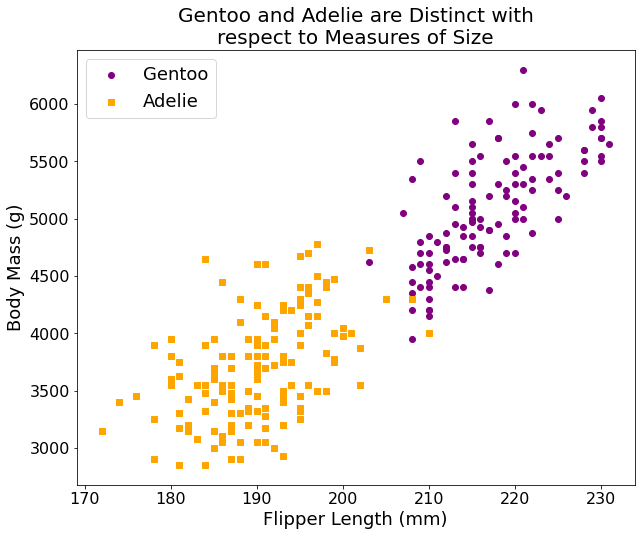

In [4]:
# We will load the different penguins into seperate series so we might colour 
# them differently
gentoo = penguins_data[penguins_data['species'] == "Gentoo"]
adelie = penguins_data[penguins_data['species'] == "Adelie"]

fig, ax = plt.subplots(figsize=(10,8))

# We will plot Flipper Length versus Body Mass, and plotting Gentoo in purple
# and Adelie in orange
plt.scatter(gentoo['flipper_length_mm'], gentoo['body_mass_g'], c='purple', label='Gentoo')
plt.scatter(adelie['flipper_length_mm'], adelie['body_mass_g'], c='orange', label='Adelie', marker='s')

# Always label your plot and axes, if not for an audience, for your future self.
plt.title('Gentoo and Adelie are Distinct with\nrespect to Measures of Size')
plt.xlabel('Flipper Length (mm)')
plt.ylabel('Body Mass (g)')
plt.legend()
None

We must first prepare the data by selecting the data we are interested in. Columns we must select are:

* The `species` column is what we wish to predict 
* The `flipper_length_mm` and `body_mass_g` columns are the features we wish to us to predict species.

We will encode `Adelie` as the number 1, and `Gentoo` as the number 0.

We can then design the model such that it will output a value between 0 and 1, indicating `Gentoo` or `Adelie`.

In [5]:
data = penguins_data.replace('Adelie', 1).replace('Gentoo', -1)

# the dataset has an extra species, "Chinstrap", that we won't concern ourselves
# with this time
data = data[data['species'] != 'Chinstrap'][['species', 'flipper_length_mm', 'body_mass_g' ]]

# Casting all values as a float will help us later
data = data.astype(float)
data.head()

,species,flipper_length_mm,body_mass_g
0,1.0,181.0,3750.0
1,1.0,186.0,3800.0
2,1.0,195.0,3250.0
4,1.0,193.0,3450.0
5,1.0,190.0,3650.0


We can need to define a vector of labels $y$, and a matrix of inputs $X$. 

$y$ should be the length of the number of samples ($n$), and $X$ should be of dimensions ($n$, $m$) where $m$ is the number of features (here, $m=2$).

A general rule is that to build a useful model, $n >> m$, or you risk overfitting.

We'll be using [PyTorch](https://pytorch.org/) [Tensors](https://pytorch.org/docs/stable/generated/torch.tensor.html#torch.tensor) in this code example. If you've NumPy before, PyTorch Tensors are very similar, but they have a couple of extremely powerful properties that we'll use later on here. Until then, however, you can just think of them as [NumPy](https://numpy.org/) [Arrays](https://numpy.org/doc/stable/reference/generated/numpy.array.html#numpy.array).

First, let's create the label vector `y`

In [6]:
import torch
y = torch.tensor(data.values[:,0])
y

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -

Second, we'll create the input matrix `x`

In [16]:
x = torch.tensor(data.values[:,1:])
x[:3]

tensor([[ 181., 3750.],
        [ 186., 3800.],
        [ 195., 3250.]], dtype=torch.float64)

## Normalising the Data

Finally, we must normalise the data. There are [numerous ways](https://en.wikipedia.org/wiki/Normalization_(statistics)) to normalise data, each with their own benefits.

For our purposes, we will center the data such that all of our training and testing points are withing the interval of $[-1,1]$. To do this, we will apply Min-Max Feature Scaling by apply the following transformation to the dataset:

$$
x = a + \dfrac{\left(x - x_{\textrm{min}}\right)\left(b - a\right)}{x_{\textrm{max}} - x_{\textrm{min}}}
$$

Where $a$ is our desired lower bound, $b$ is our desired upper bound, $x_{\textrm{min}}$ is the smallest number in the dataset, and $x_{\textrm{max}}$ is the largest number in the dataset. Here, we set $a = -1$ and $b = 1$.

We could have also used a $z$-score, but I personally like the fact that scaling our in this way data does not require that we assume our dataset belongs to a normal distribution.

In [8]:
def normalise(X: torch.TensorType, a: int = -1, b: int = 1, x_min = None, x_max = None):
  '''
  Applies Min-Max Feature Scaling.

  :param X: The array that is to be normalised
  :param a: The lower-bound of the scaled data
  :param b: The upper-bound of the scaled data
  '''

  if x_min is None:
    x_min = torch.min(X, axis=0).values

  if x_max is None:
    x_max = torch.max(X, axis=0).values

  denominator = x_max - x_min
  numerator = (X - x_min)*(b-a)

  return a + numerator/denominator

We can now verify that the minimum and maximum values of the dataset are indeed $-1$ and $1$, and also inspect the mean and standard deviation of the dataset.

In [9]:
from tabulate import tabulate

x_normalised = normalise(x)

print(tabulate([
    ['mean', torch.mean(x_normalised)],
    ['std', torch.std(x_normalised)],
    ['min', torch.min(x_normalised)],
    ['max', torch.max(x_normalised)]
]))

----  ----------
mean  -0.0580619
std    0.504794
min   -1
max    1
----  ----------


## Adding Bias Term

As pointed out earlier, we can simplify training the model by adding a column of ones to the dataset. This will represent the bias terms.

In [10]:
ones = torch.ones((x_normalised.shape[0], x_normalised.shape[1]+1))
ones[:, :2] = x_normalised

x_normalised = ones

## Splitting the Dataset

We will split our dataset in three parts:

* Training Dataset ($80\%$ of the total dataset)
* Test Dataset ($10\%$ of the total dataset)
* Validation Dataset ($10\%$ of the total dataset)

We will use the training dataset to train the dataset, the testing dataset to chose hyper-parameters, and the validation dataset will be used to determine the final accuracy.

To do this, we'll shuffle the dataset and prepare the splits.

In [11]:
idx = torch.randperm(len(x_normalised))
x_normalised = x_normalised[idx]
y = y[idx]

# We can inspect the labels. 
# We expect some of these to be 0s and 1s
y[:10]

tensor([-1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.], dtype=torch.float64)

In [12]:
num_train = int(len(x) * 0.8)
num_test = int(len(x) * 0.1)

x_train = x_normalised[0:num_train]
x_test = x_normalised[num_train:num_train+num_test]
x_valid = x_normalised[num_train+num_test:]

y_train = y[0:num_train]
y_test = y[num_train:num_train+num_test]
y_valid = y[num_train+num_test:]

print(tabulate([
  ["x_train", x_train.shape],
  ["x_test", x_test.shape],
  ["x_valid", x_valid.shape],
  ["y_train", y_train.shape],
  ["y_test", y_test.shape],
  ["y_valid", y_valid.shape],
]))

-------  --------------------
x_train  torch.Size([212, 3])
x_test   torch.Size([26, 3])
x_valid  torch.Size([27, 3])
y_train  torch.Size([212])
y_test   torch.Size([26])
y_valid  torch.Size([27])
-------  --------------------


# Perceptron Learning

## Initialising Perceptron Weights

The weights of the perceptron need some base value. We can use zeroes, or ones, or random values. There are even specific distributions that have been found to be particularly well suited for drawing random weights from (*e.g.*: [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [Kaiming](https://arxiv.org/abs/1502.01852) initialisation). Both of those distributions are included in PyTorch and we'll be using them at a later point.

We'll just use random number between -1 and 1 for now.

In [13]:
W = torch.rand((1, x_train.shape[1]), requires_grad=True) # requires_grad tells PyTorch that at some point, we are going to use PyTorch to compute the gradient of this tensor. 

# torch.rand returns a value between 0 and 1, so we're going to scale them to
# between -1 and 1.
W = 1 - (W*2)
W

tensor([[-0.3653,  0.9421,  0.8912]], grad_fn=<RsubBackward1>)

## The Forward Pass

We can define the forward pass quite succinctly as displayed below. If we recall from above, the forward pass formula is: 

$$
f(X)=  \begin{cases} 
      1 & W\cdot X + b > 0\\
      -1 & W\cdot X + b < 0
   \end{cases}
$$

which we can restate as

$$
f(X) = H\left(\sum_{i=0}^n w_i x_i\right)
$$

In [15]:
# The forward-pass of the perceptron function is defined as follows
f = lambda x: torch.sign(torch.sum(x*W, axis=1))

# You can run the forward-pass on our sample as
f(x_train)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<SignBackward>)

To illustrate how choice of initial values matters, we can see how this first forward pass has various accuracies.

In [ ]:
def forward(input):
  W = torch.rand((1, x_train.shape[1]), requires_grad=True)
  W = 1 - (W*2) # rescale to -1 to 1 from 0 to 1

  f = lambda x: torch.sign(torch.sum(x*W, axis=1))

  return f(input)

for i in range(10):
  acc = torch.sum(forward(x_train) == y_train)/float(len(y_train))
  print(f"Accuracy of Trial {i}: {acc}")

Accuracy of Trial 0: 0.5471698045730591
Accuracy of Trial 1: 0.5660377144813538
Accuracy of Trial 2: 0.13679245114326477
Accuracy of Trial 3: 0.4528301954269409
Accuracy of Trial 4: 0.07075471431016922
Accuracy of Trial 5: 0.4528301954269409
Accuracy of Trial 6: 0.07075471431016922
Accuracy of Trial 7: 0.4528301954269409
Accuracy of Trial 8: 0.4669811427593231
Accuracy of Trial 9: 0.5943396091461182


## Perceptron Loss Function

The original loss function for Rosenblatt's Perceptron was a [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss) with a threshold of 0. We can state it as follows:

$$
\textrm{loss} = -\sum_{i \in M} \hat{y}_iwx_i
$$


Where $y_i$ is the true label for the $i^{\textrm{th}}$ sample, $\hat{y}_i$ is the predicted label, and $M$ is the set of indices of incorrectly classified samples. That is to say, we sum the loss of all the incorrectly labelled samples.

In [ ]:
def perceptron_loss(y_observed, y_expected):
  return torch.clamp(-1 * y_expected * y_observed, min=0)

We can plot out all the possible loss values for samples, based on their true value:

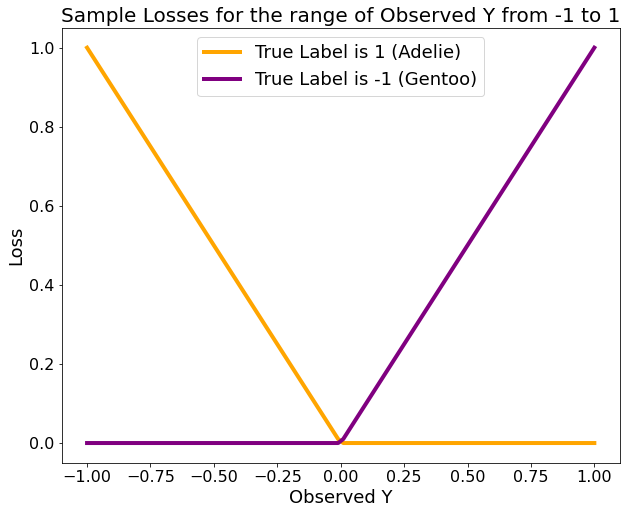

In [ ]:
plt.subplots(figsize=(10,8))
plt.plot(torch.linspace(-1,1,100), perceptron_loss(torch.linspace(-1,1,100), 1), lw='4', c="orange", label="True Label is 1 (Adelie)")
plt.plot(torch.linspace(-1,1,100), perceptron_loss(torch.linspace(-1,1,100), -1), lw='4', c="purple", label="True Label is -1 (Gentoo)")
plt.xlabel('Observed Y')
plt.ylabel('Loss')
plt.legend()
plt.title('Sample Losses for the range of Observed Y from -1 to 1')
None

In [ ]:
class Perceptron:
  def __init__(self, num_features):
    """
    Perceptron is a PyTorch implementation of a
    perceptron.

    :param num_features: The number of features the perceptron operates on.
    """
    self.num_features = num_features

    # Weights are here initialised randomly
    self.W = torch.rand((1, self.num_features), requires_grad=True)
    self.W = 1 - (self.W*2)


  def sign(self, x):
    """
    Sign function.
    The sign function is applied to each of the elements of the 1D input.
    :params x: A 1D numpy array
    :returns: x with the sign function applied
    """
    x2 = x.clone()
    x2[x2 > 0] = 1
    x2[x2 <= 0] = 0
    return x2

  def forward(self, x):
    return self.sign(torch.sum(self.W*x, axis=1))

## Optimising Weights: Gradient Descent

[Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent) is an algorithm for finding the lowest value of a function (that function needs to be [differentiable](https://en.wikipedia.org/wiki/Differentiable_function)). 

Intuitively, we can think of this as an algorithm to find the lowest "valley" in the "mountain ranges" of a function when you can only see a few feet ahead of you.

![Gradient Descent Example](https://2.bp.blogspot.com/-w3EFnDuIyf4/V1KrbOK944I/AAAAAAAAFOk/BHszQSE-w5Q0i0aQEtIsuoaIclkaDuBowCLcB/s320/rosenbrock-nag%2Bcopy.png)

(source: [DataScience Deep Dive](https://dsdeepdive.blogspot.com/2016/03/optimizations-of-gradient-descent.html))


### Updating the Weights

The update rule for Gradient Descent has us applying the following update rule:

$$
W = W - \alpha\nabla L(W)
$$

Where $W$ are the weights of the model, $\nabla L(W)$ is the [gradient](https://en.wikipedia.org/wiki/Gradient) of the loss function, and $\alpha$ is a so-called "learning rate".

If you're not familiar with what a gradient is, I like Khan Academy's description: ["The gradient captures all the partial derivative information of a scalar-valued multivariable function"](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/gradient-and-directional-derivatives/v/gradient).


### Side-note: PyTorch's Autograd
PyTorch helps us by offering us a very powerful tool: [Automatic Differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). PyTorch's automatic differentiation allows us to calculate the derivatives of python functions quickly and automatically. This is a huge part of why we're using `torch.tensor` instead of `numpy.array` in this code.

For a very useful overview of how PyTorch's autodifferentiation works, specifically, the [PyTorch Documentation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) is your best friend.

Here's an example:

Let's begin with a python function $f(x) = x^3$



In [ ]:
def f(x):
  return torch.pow(x, torch.tensor(3))

# Let's calculate f(4) = 4^3 = 64
f(4)

tensor(64)

We know that the derivative $\dfrac{\partial f}{\partial x} \textrm{where } x = 4$ is $3\times4^2 = 48$.

To get this result, we can run the following code:

In [ ]:
# setting the "requires_grad" tells PyTorch to keep track of x's gradients
x = torch.tensor(4., requires_grad=True)

# this calculates all the gradients in the call "f(x)".
# This is sort of like declaring the "df" part of the partial derivative "df/dx"
f(x).backward()

# To access the value of the gradient of a variable, use the "grad" property
# This is sort of like declaring the "dx" part of the partial derivative "df/dx"
x.grad

tensor(48.)

Of course, while this is not particularly useful for tiny functions, we can make arbitrary complex functions and get derivatives for them this way (provided the functions are differentiable).

In [ ]:
Wsgd = torch.ones(1,3, requires_grad=True)

training_losses = []
test_losses = []
weights = []

for _ in range(15):

  incorrect_idx = (torch.sign(torch.sum(Wsgd*x_train)) != y_train)

  loss = -1 * (Wsgd * x_train[incorrect_idx] * y_train[incorrect_idx].reshape(-1,1)).mean()
  loss = torch.clamp(loss, min=0)

  training_losses.append(loss)

  loss.backward()

  with torch.no_grad():
    Wsgd -= Wsgd.grad
    Wsgd.grad.zero_()
    weights.append(Wsgd.detach().clone())

    test_incorrect_idx = (torch.sign(torch.sum(Wsgd*x_test)) != y_test)

    test_loss = -1 * (Wsgd * x_test[test_incorrect_idx] * y_test[test_incorrect_idx].reshape(-1,1)).mean()
    test_loss = torch.clamp(test_loss, min=0)
    test_losses.append(test_loss)


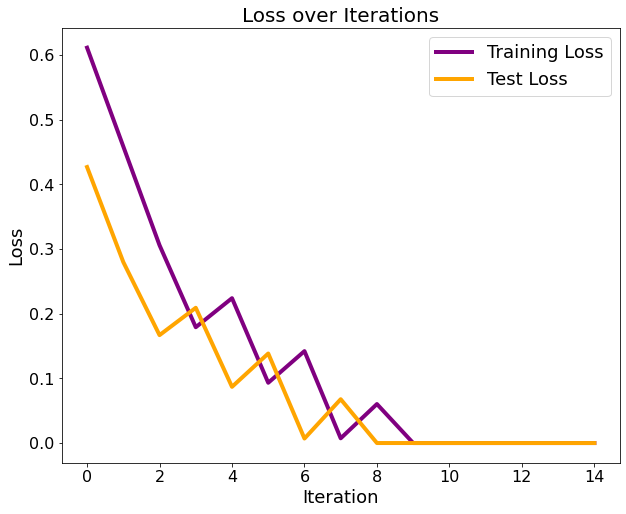

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(training_losses, lw=4, color='purple', label='Training Loss')
plt.plot(test_losses, lw=4, color='orange', label='Test Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()

In [ ]:
Wsgd

tensor([[-4.6046e-01, -1.0655e-01, -1.2219e-06]], requires_grad=True)

In [ ]:
torch.sum(torch.sign(torch.sum(Wsgd*x_train, axis=1)) == y_train)/float(len(y_train))

tensor(0.9906)

In [ ]:
weights

[tensor([[0.8225, 0.8996, 0.6667]]),
 tensor([[0.6449, 0.7992, 0.3333]]),
 tensor([[ 4.6739e-01,  6.9887e-01, -7.7486e-07]]),
 tensor([[0.3356, 0.5308, 0.3333]]),
 tensor([[ 1.5810e-01,  4.3040e-01, -9.2387e-07]]),
 tensor([[0.0264, 0.2623, 0.3333]]),
 tensor([[-1.5118e-01,  1.6192e-01, -1.0729e-06]]),
 tensor([[-0.2829, -0.0062,  0.3333]]),
 tensor([[-4.6046e-01, -1.0655e-01, -1.2219e-06]]),
 tensor([[-4.6046e-01, -1.0655e-01, -1.2219e-06]]),
 tensor([[-4.6046e-01, -1.0655e-01, -1.2219e-06]]),
 tensor([[-4.6046e-01, -1.0655e-01, -1.2219e-06]]),
 tensor([[-4.6046e-01, -1.0655e-01, -1.2219e-06]]),
 tensor([[-4.6046e-01, -1.0655e-01, -1.2219e-06]]),
 tensor([[-4.6046e-01, -1.0655e-01, -1.2219e-06]])]

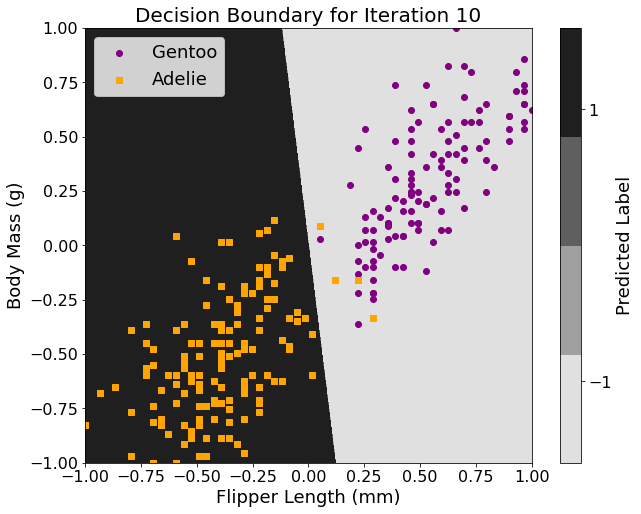

In [ ]:
import numpy as np

iteration = 10

# We will load the different penguins into seperate series so we might colour 
# them differently
gentoo = penguins_data[penguins_data['species'] == "Gentoo"]
adelie = penguins_data[penguins_data['species'] == "Adelie"]

fig, ax = plt.subplots(1,1, figsize=(10,8))

x = torch.linspace(-1,1,1000)
y = torch.linspace(-1,1,1000)

X, Y = torch.meshgrid(x, y)

def boundary(X, Y):
  return np.sign((weights[iteration][0][0].detach() * X) + (weights[iteration][0][1].detach() * Y) + weights[iteration][0][2].detach())

cs = ax.contourf(X, Y, boundary(X, Y), cmap='binary', levels=2)
#cs.set

# We will plot Flipper Length versus Body Mass, and plotting Gentoo in purple
# and Adelie in orange
gentoo_flipper = normalise(torch.tensor(gentoo['flipper_length_mm'].values),
                           x_min=data.flipper_length_mm.min(),
                           x_max=data.flipper_length_mm.max())

gentoo_mass = normalise(torch.tensor(gentoo['body_mass_g'].values),
                        x_min=data.body_mass_g.min(),
                           x_max=data.body_mass_g.max())

adelie_flipper = normalise(torch.tensor(adelie['flipper_length_mm'].values),
                           x_min=data.flipper_length_mm.min(),
                           x_max=data.flipper_length_mm.max())

adelie_mass = normalise(torch.tensor(adelie['body_mass_g'].values),
                        x_min=data.body_mass_g.min(),
                        x_max=data.body_mass_g.max())

ax.scatter(gentoo_flipper, gentoo_mass, c='purple', label='Gentoo')
ax.scatter(adelie_flipper, adelie_mass, c='orange', label='Adelie', marker='s')


ax.set_title(f'Decision Boundary for Iteration {iteration}')
ax.set_xlabel('Flipper Length (mm)')
ax.set_ylabel('Body Mass (g)')
ax.legend()
plt.colorbar(cs, ticks=[-1,1], label="Predicted Label")
None